In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# No need for an open connection, because you're only doing a single query
engine.dispose()


insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


In [3]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

# `Y` is the target variable
Y = insurance_df['charges']

# `X` is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi']]

# Add a constant to the model because it's best practice
# to do so every time!
X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     986.5
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:51:53   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.163e+04    947.267    -12.281      0.0

The estimated model is: 𝑐ℎ𝑎𝑟𝑔𝑒𝑠=−11633.50−109.04𝑖𝑠_𝑚𝑎𝑙𝑒+23833.87𝑖𝑠_𝑠𝑚𝑜𝑘𝑒𝑟+259.45𝑎𝑔𝑒+323.05𝑏𝑚𝑖(𝑒𝑞.1)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1365.
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:51:53   Log-Likelihood:                -13265.
No. Observations:                1338   AIC:                         2.654e+04
Df Residuals:                    1332   BIC:                         2.657e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2071.0750    840.644     -2.464

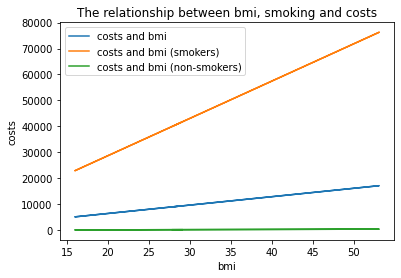

In [4]:
# add the interaction variable of BMI and the is_smoker dummy to the model.
# `Y` is the target variable
Y = insurance_df['charges']

# This is the interaction between BMI and smoking
insurance_df["bmi_is_smoker"] = insurance_df.bmi * insurance_df.is_smoker

# `X` is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi', "bmi_is_smoker"]]

# Add a constant to the model because it's best practice
# to do so every time
X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# Print the summary results
print(results.summary())


costs_bmi = insurance_df.bmi * 323.0511
costs_bmi_smokers = insurance_df.bmi * 1435.6081
costs_bmi_non_smokers = insurance_df.bmi * 7.9686


plt.plot(insurance_df.bmi, costs_bmi)
plt.plot(insurance_df.bmi, costs_bmi_smokers)
plt.plot(insurance_df.bmi, costs_bmi_non_smokers)
plt.legend(["costs and bmi", "costs and bmi (smokers)", "costs and bmi (non-smokers)"])
plt.xlabel("bmi")
plt.ylabel("costs")
plt.title("The relationship between bmi, smoking and costs")

plt.show()